## **Previsão de Aprovação de Empréstimos**

**Importação das bibliotecas**

In [4080]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# bibliotecas adicionais (estatística, explicabilidade, tuning)
import statsmodels.api as sm
import scipy.stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,
    brier_score_loss, matthews_corrcoef, precision_score, recall_score, f1_score,
    confusion_matrix
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
import plotly.figure_factory as ff

**Carregamento dos dados**

In [4081]:
df = pd.read_csv("C:/Users/Cliente/Downloads/loan_approval.csv")

In [4082]:
df.head()

,Applicant_ID,Applicant_Income,Coapplicant_Income,Employment_Status,Age,Marital_Status,Dependents,Credit_Score,Existing_Loans,DTI_Ratio,Savings,Collateral_Value,Loan_Amount,Loan_Term,Loan_Purpose,Property_Area,Education_Level,Gender,Employer_Category,Loan_Approved
0,1.0,17795.0,1387.0,Salaried,51.0,Married,0.0,637.0,4.0,0.53,19403.0,45638.0,16619.0,84.0,Personal,Urban,Not Graduate,Female,Private,No
1,2.0,2860.0,2679.0,Salaried,46.0,Married,3.0,621.0,2.0,0.30,2580.0,49272.0,38687.0,NaN,Car,Semiurban,Graduate,NaN,Private,No
2,3.0,7390.0,2106.0,Salaried,25.0,Single,2.0,674.0,4.0,0.20,13844.0,6908.0,27943.0,72.0,NaN,Urban,NaN,Female,Government,Yes
3,4.0,13964.0,8173.0,Salaried,40.0,Married,2.0,579.0,3.0,0.31,9553.0,10844.0,27819.0,60.0,Business,Rural,Graduate,Female,Government,No
4,5.0,13284.0,4223.0,Self-employed,31.0,Single,2.0,721.0,1.0,0.29,9386.0,37629.0,12741.0,72.0,Car,NaN,Graduate,Male,Private,Yes


### Dicionário de Variáveis

| **Variável** | **Descrição** |
|:--------------|:--------------|
| **Applicant_ID** | Identificador único do solicitante |
| **Applicant_Income** | Renda mensal do solicitante |
| **Coapplicant_Income** | Renda mensal do co-solicitante (se houver) |
| **Employment_Status** | Situação profissional (ex: assalariado, autônomo, desempregado) |
| **Age** | Idade do solicitante |
| **Marital_Status** | Estado civil (ex: solteiro, casado) |
| **Dependents** | Número de dependentes |
| **Credit_Score** | Pontuação de crédito |
| **Existing_Loans** | Quantidade de empréstimos já existentes |
| **DTI_Ratio** | Relação dívida/renda (*Debt-to-Income Ratio*) |
| **Savings** | Valor da poupança ou reserva financeira |
| **Collateral_Value** | Valor do bem dado em garantia |
| **Loan_Amount** | Valor solicitado do empréstimo |
| **Loan_Term** | Prazo do empréstimo (em meses ou anos) |
| **Loan_Purpose** | Finalidade do empréstimo (ex: casa, carro, educação) |
| **Property_Area** | Localização do imóvel (urbana, semiurbana ou rural) |
| **Education_Level** | Nível de escolaridade do solicitante |
| **Gender** | Gênero (masculino, feminino, outro) |
| **Employer_Category** | Setor do emprego (público, privado, autônomo etc.) |
| **Loan_Approved** | **Variável-alvo** → `Yes` (Aprovado) / `No` (Negado) |


Remoção de identificador: a coluna `Applicant_ID` é um identificador sem informação preditiva direta. 


In [4083]:
df=df.drop("Applicant_ID", axis=1)

In [4084]:
df.head()

,Applicant_Income,Coapplicant_Income,Employment_Status,Age,Marital_Status,Dependents,Credit_Score,Existing_Loans,DTI_Ratio,Savings,Collateral_Value,Loan_Amount,Loan_Term,Loan_Purpose,Property_Area,Education_Level,Gender,Employer_Category,Loan_Approved
0,17795.0,1387.0,Salaried,51.0,Married,0.0,637.0,4.0,0.53,19403.0,45638.0,16619.0,84.0,Personal,Urban,Not Graduate,Female,Private,No
1,2860.0,2679.0,Salaried,46.0,Married,3.0,621.0,2.0,0.30,2580.0,49272.0,38687.0,NaN,Car,Semiurban,Graduate,NaN,Private,No
2,7390.0,2106.0,Salaried,25.0,Single,2.0,674.0,4.0,0.20,13844.0,6908.0,27943.0,72.0,NaN,Urban,NaN,Female,Government,Yes
3,13964.0,8173.0,Salaried,40.0,Married,2.0,579.0,3.0,0.31,9553.0,10844.0,27819.0,60.0,Business,Rural,Graduate,Female,Government,No
4,13284.0,4223.0,Self-employed,31.0,Single,2.0,721.0,1.0,0.29,9386.0,37629.0,12741.0,72.0,Car,NaN,Graduate,Male,Private,Yes


**Checagem de valores ausentes**

In [4085]:
df.isnull().sum()

Applicant_Income      50
Coapplicant_Income    50
Employment_Status     50
Age                   50
Marital_Status        50
Dependents            50
Credit_Score          50
Existing_Loans        50
DTI_Ratio             50
Savings               50
Collateral_Value      50
Loan_Amount           50
Loan_Term             50
Loan_Purpose          50
Property_Area         50
Education_Level       50
Gender                50
Employer_Category     50
Loan_Approved         50
dtype: int64

Precisamos tratar nulos antes do ajuste de modelos para evitar erros e perda de amostras.

### **Resumo estatístico**

In [4086]:
print(df.describe())

       Applicant_Income  Coapplicant_Income         Age  Dependents  \
count        950.000000          950.000000  950.000000  950.000000   
mean       10852.571579         5082.455789   39.971579    1.474737   
std         5061.632859         2943.161570   11.139797    1.105067   
min         2009.000000            1.000000   21.000000    0.000000   
25%         6730.750000         2472.750000   30.250000    1.000000   
50%        10548.000000         5205.500000   40.000000    1.000000   
75%        15190.000000         7620.750000   49.000000    2.000000   
max        19988.000000         9996.000000   59.000000    3.000000   

       Credit_Score  Existing_Loans   DTI_Ratio       Savings  \
count    950.000000      950.000000  950.000000    950.000000   
mean     676.033684        1.950526    0.347263   9940.452632   
std       71.346015        1.406246    0.144341   5860.736885   
min      550.000000        0.000000    0.100000     65.000000   
25%      616.250000        1.000000

**Informações do DataFrame**

In [4087]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Applicant_Income    950 non-null    float64
 1   Coapplicant_Income  950 non-null    float64
 2   Employment_Status   950 non-null    object 
 3   Age                 950 non-null    float64
 4   Marital_Status      950 non-null    object 
 5   Dependents          950 non-null    float64
 6   Credit_Score        950 non-null    float64
 7   Existing_Loans      950 non-null    float64
 8   DTI_Ratio           950 non-null    float64
 9   Savings             950 non-null    float64
 10  Collateral_Value    950 non-null    float64
 11  Loan_Amount         950 non-null    float64
 12  Loan_Term           950 non-null    float64
 13  Loan_Purpose        950 non-null    object 
 14  Property_Area       950 non-null    object 
 15  Education_Level     950 non-null    object 
 16  Gender 

Separação de variáveis por tipo
`categorical_col`: colunas do tipo objeto (categóricas)
`numerical_col`: colunas numéricas (int/float)

In [4088]:
categorical_col=df.select_dtypes(include=['object']).columns
numerical_col=df.select_dtypes(include=['int64', 'float64']).columns

In [4089]:
categorical_col

Index(['Employment_Status', 'Marital_Status', 'Loan_Purpose', 'Property_Area',
       'Education_Level', 'Gender', 'Employer_Category', 'Loan_Approved'],
      dtype='object')

In [4090]:
numerical_col

Index(['Applicant_Income', 'Coapplicant_Income', 'Age', 'Dependents',
       'Credit_Score', 'Existing_Loans', 'DTI_Ratio', 'Savings',
       'Collateral_Value', 'Loan_Amount', 'Loan_Term'],
      dtype='object')

**Imputação `SimpleImputer` (Scikit-Learn) para preencher nulos**

Estratégias:

* Numéricas → mediana (robusta a outliers)

* Categóricas → categoria mais frequente (evita criação de rótulos artificiais)


**Imputação numérica**

Substitui nulos das colunas numéricas pela mediana da respectiva coluna.


In [4091]:
from sklearn.impute import SimpleImputer
num_imputer=SimpleImputer(strategy='median')
df[numerical_col]=num_imputer.fit_transform(df[numerical_col])

**Imputação categórica**

Substitui nulos das colunas categóricas pelo valor mais frequente de cada coluna.


In [4092]:
from sklearn.impute import SimpleImputer
cat_imputer=SimpleImputer(strategy='most_frequent')
df[categorical_col]=cat_imputer.fit_transform(df[categorical_col])

**Verificação pós-imputação**

Confere se ainda restaram valores ausentes no DataFrame.



In [4093]:
df.isnull().sum()

Applicant_Income      0
Coapplicant_Income    0
Employment_Status     0
Age                   0
Marital_Status        0
Dependents            0
Credit_Score          0
Existing_Loans        0
DTI_Ratio             0
Savings               0
Collateral_Value      0
Loan_Amount           0
Loan_Term             0
Loan_Purpose          0
Property_Area         0
Education_Level       0
Gender                0
Employer_Category     0
Loan_Approved         0
dtype: int64

## **Análise Exploratória (EDA)**

Investigação inicial de frequências e distribuições para entender o perfil dos solicitantes.

Contagem de `Loan_Approved`
Quantos casos aprovados e rejeitados existem na base (balanceamento da classe).

In [4094]:
print(df['Loan_Approved'].value_counts())

Loan_Approved
No     702
Yes    298
Name: count, dtype: int64


### **Estatísticas descritivas e dispersão**

In [4095]:
df[numerical_col].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95]).T

,count,mean,std,min,25%,50%,75%,90%,95%,max
Applicant_Income,1000.0,10837.3430,4933.786501,2009.0,6857.00,10548.00,14973.25,17981.30,19100.05,19988.0
Coapplicant_Income,1000.0,5088.6080,2868.688959,1.0,2701.25,5205.50,7452.75,9076.10,9508.40,9996.0
Age,1000.0,39.9730,10.857447,21.0,31.00,40.00,49.00,55.00,57.00,59.0
Dependents,1000.0,1.4510,1.082021,0.0,1.00,1.00,2.00,3.00,3.00,3.0
Credit_Score,1000.0,676.1320,69.538984,550.0,618.00,678.00,735.00,771.00,785.05,799.0
Existing_Loans,1000.0,1.9530,1.370646,0.0,1.00,2.00,3.00,4.00,4.00,4.0
DTI_Ratio,1000.0,0.3469,0.140692,0.1,0.23,0.34,0.47,0.55,0.57,0.6
Savings,1000.0,9937.4550,5712.204195,65.0,4964.00,9880.50,14784.75,17818.30,18801.45,19996.0
Collateral_Value,1000.0,24778.7030,13982.481238,36.0,13166.00,24321.00,36396.00,44658.10,47652.50,49954.0
Loan_Amount,1000.0,20557.2090,11213.558434,1015.0,10478.25,21210.50,29683.25,36140.70,38183.35,39995.0


| Variável               | Interpretação Estatística        | Observação Analítica                                                                                                                                |
| ---------------------- | -------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Applicant_Income**   | Média ≈ 10.837, desvio ≈ 4.934   | Renda dos solicitantes varia bastante — alta dispersão (coeficiente de variação ≈ 45%). Há forte assimetria positiva (alguns com renda muito alta). |
| **Coapplicant_Income** | Média ≈ 5.088, desvio ≈ 2.869    | Em média, co-solicitantes ganham metade do titular. O valor mínimo (1.0) sugere casos sem renda formal. Distribuição também assimétrica.            |
| **Age**                | Média ≈ 40 anos, amplitude 21–59 | Perfil típico de adultos em idade laboral ativa. Intervalo interquartil (31–49) mostra concentração em meia-idade.                                  |
| **Dependents**         | Média ≈ 1,45, máximo 3           | A maioria tem 1 a 2 dependentes.                                                                                                                    |
| **Credit_Score**       | Média ≈ 676, desvio ≈ 69         | Distribuição próxima à normal, centrada em score médio-alto. A faixa 550–800 é típica de escala de crédito padrão.                                  |
| **Existing_Loans**     | Média ≈ 1,95, máximo 4           | A maioria possui 1–2 empréstimos ativos. Possível relação negativa com aprovação (maior endividamento → maior risco).                               |
| **DTI_Ratio**          | Média ≈ 0,35 (35%)               | O índice *Debt-to-Income* (dívida/renda) médio é aceitável. Valores acima de 0,5 (50%) indicam endividamento mais arriscado.                        |
| **Savings**            | Média ≈ 9.937, desvio ≈ 5.712    | Grande dispersão — alguns clientes têm reservas financeiras muito altas.                                                                            |
| **Collateral_Value**   | Média ≈ 24.778, desvio ≈ 13.982  | Valor da garantia (colateral) é variável; há grande amplitude (36 até ~50 mil). Indica heterogeneidade nos tipos de bens.                           |
| **Loan_Amount**        | Média ≈ 20.557, desvio ≈ 11.213  | Valores de empréstimo variam de 1.015 a ~40 mil. Quartis (10k–30k) indicam concentração em empréstimos médios.                                      |
| **Loan_Term**          | Média ≈ 48 meses, desvio ≈ 23,6  | Mediana = 48 → metade dos contratos são de 4 anos. 75% até 6 anos (72 meses).                                                                       |


#### **Gráfico: Status do Empréstimo**


In [4096]:
loan_status_count = df['Loan_Approved'].value_counts().reset_index()
loan_status_count.columns = ["Loan_approved", "count"]
fig_loan_status = px.bar( loan_status_count,
                         x='Loan_approved',
                         y='count', color='Loan_approved',
                         text='count',
                         title='Distribuição do Status de Empréstimos',
                         labels={'Loan_approved': 'Status do Empréstimo', 'count': 'Número de Solicitações'} )

fig_loan_status.update_traces(textposition='outside')
fig_loan_status.update_layout( xaxis=dict(tickmode='array',
                                          tickvals=[0, 1],
                                          ticktext=['Rejeitado (0)', 'Aprovado (1)']),
                                          showlegend=False, yaxis_title='Quantidade',
                                          xaxis_title='Status do Empréstimo', )

max_y = loan_status_count['count'].max()
fig_loan_status.update_yaxes(range=[0, max_y * 1.15])
fig_loan_status.update_layout(margin=dict(t=80))
fig_loan_status.show()

#### **Gráfico: Distribuição de Gênero**


In [4097]:
# contagem dos gêneros
gender_count = df['Gender'].value_counts().reset_index()
gender_count.columns = ["Gender", "count"]

# substitui os nomes
gender_count['Gender'] = gender_count['Gender'].replace({
    'Male': 'Masculino',
    'Female': 'Feminino'
})

fig_gender = px.bar(
    gender_count,
    x='Gender',
    y='count',
    color='Gender',
    text='count',
    title='Distribuição de Gênero',
    labels={'Gender': 'Gênero', 'count': 'Quantidade'}
)

fig_gender.update_traces(textposition='outside')
fig_gender.update_layout(
    showlegend=False,
    yaxis_title='Quantidade',
    xaxis_title='Gênero',
)

max_y = gender_count['count'].max()
fig_gender.update_yaxes(range=[0, max_y * 1.15])
fig_gender.update_layout(margin=dict(t=80))

fig_gender.show()


Contagem de `Marital_Status`

Frequência por estado civil com rótulos traduzidos.


In [4098]:
df['Marital_Status'].value_counts()

Marital_Status
Married    643
Single     357
Name: count, dtype: int64

#### **Gráfico: Distribuição por Estado Civil**


In [4099]:
# contagem do estado civil
marital_count = df['Marital_Status'].value_counts().reset_index()
marital_count.columns = ["Marital_Status", "count"]

# tradução dos valores 
marital_count['Marital_Status'] = marital_count['Marital_Status'].replace({
    'Married': 'Casado(a)',
    'Single': 'Solteiro(a)'
})

fig_marital = px.bar(
    marital_count,
    x='Marital_Status',
    y='count',
    color='Marital_Status',
    text='count',
    title='Distribuição por Estado Civil',
    labels={'Marital_Status': 'Estado Civil', 'count': 'Quantidade'}
)

fig_marital.update_traces(textposition='outside')
fig_marital.update_layout(
    showlegend=False,
    yaxis_title='Quantidade',
    xaxis_title='Estado Civil',
)

max_y = marital_count['count'].max()
fig_marital.update_yaxes(range=[0, max_y * 1.15])
fig_marital.update_layout(margin=dict(t=80))

fig_marital.show()



#### **Histograma: Distribuição da renda do solicitante**

In [4100]:
fig_applicant_income = px.histogram(
    df,
    x='Applicant_Income',
    nbins=30,  # ajusta número de intervalos
    color_discrete_sequence=['#5DADE2'],  # azul suave
    title='Distribuição da Renda do Solicitante',
    labels={'Applicant_Income': 'Renda do Solicitante (R$)'}
)

# adiciona linha da média
mean_income = df['Applicant_Income'].mean()
fig_applicant_income.add_vline(
    x=mean_income,
    line_dash='dash',
    line_color='red',
    annotation_text=f"Média: {mean_income:.0f}",
    annotation_position='top right'
)

fig_applicant_income.update_traces(
    marker_line_color='black',
    marker_line_width=1
)
fig_applicant_income.update_layout(
    xaxis_title='Renda do Solicitante (R$)',
    yaxis_title='Frequência',
    plot_bgcolor='white',
    margin=dict(t=80, l=60, r=40, b=60)
)

fig_applicant_income.show()


#### **Histograma: Distribuição da renda do co-solicitante** 


In [4101]:
fig_coapplicant_income = px.histogram(
    df,
    x='Coapplicant_Income',
    nbins=30,
    color_discrete_sequence=['#48C9B0'],  # verde-água suave (diferente do azul anterior)
    title='Distribuição da Renda do Co-Solicitante',
    labels={'Coapplicant_Income': 'Renda do Co-Solicitante (R$)'}
)

# adiciona linha da média
mean_coincome = df['Coapplicant_Income'].mean()
fig_coapplicant_income.add_vline(
    x=mean_coincome,
    line_dash='dash',
    line_color='red',
    annotation_text=f"Média: {mean_coincome:.0f}",
    annotation_position='top right'
)

# ajustes visuais
fig_coapplicant_income.update_traces(
    marker_line_color='black',
    marker_line_width=1
)
fig_coapplicant_income.update_layout(
    xaxis_title='Renda do Co-Solicitante (R$)',
    yaxis_title='Frequência',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(t=80, l=60, r=40, b=60)
)

fig_coapplicant_income.show()


#### **Boxplot: Renda × Aprovação**

In [4102]:
fig_income = px.box(
    df,
    x='Loan_Approved',
    y='Applicant_Income',
    color='Loan_Approved',
    points='all',  # mostra todos os pontos individuais
    title='Distribuição da Renda do Solicitante por Status de Empréstimo',
    labels={
        'Loan_Approved': 'Status do Empréstimo',
        'Applicant_Income': 'Renda do Solicitante (R$)'
    },
    color_discrete_map={
        0: '#E74C3C',  # vermelho (Rejeitado)
        1: '#27AE60'   # verde (Aprovado)
    }
)

fig_income.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['Rejeitado (0)', 'Aprovado (1)']
    ),
    yaxis_title='Renda do Solicitante (R$)',
    xaxis_title='Status do Empréstimo',
    title_font=dict(size=20, family='Arial', color='black'),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(size=14),
    showlegend=False
)

fig_income.update_traces(
    boxmean='sd',  # adiciona média e desvio padrão
    jitter=0.4,    # dispersão dos pontos
    marker=dict(opacity=0.6, size=5)
)

fig_income.show()


#### **Histograma: Score de Crédito × Aprovação**


In [4103]:
fig_credit_score = px.histogram(
    df,
    x='Credit_Score',
    color='Loan_Approved',
    barmode='group',  # barras lado a lado (comparação direta)
    nbins=25,
    text_auto=True,   # mostra os valores no topo das barras
    title='Distribuição do Score de Crédito por Status de Empréstimo',
    labels={
        'Credit_Score': 'Score de Crédito',
        'Loan_Approved': 'Status do Empréstimo'
    },
    color_discrete_map={
        0: '#E74C3C',  # vermelho para Rejeitado
        1: '#2ECC71'   # verde para Aprovado
    }
)

fig_credit_score.update_traces(
    textfont_size=12,
    textangle=0,
    textposition='outside',
    cliponaxis=False
)

fig_credit_score.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(
        title='Score de Crédito',
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)',
        zeroline=False
    ),
    yaxis=dict(
        title='Número de Solicitantes',
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)'
    ),
    legend=dict(
        title='Status do Empréstimo',
        orientation='h',
        yanchor='bottom',
        y=1.05,
        xanchor='center',
        x=0.5,
        font=dict(size=13)
    )
)

fig_credit_score.show()


### **Distribuição do DTI_Ratio**

<Axes: xlabel='DTI_Ratio', ylabel='Count'>

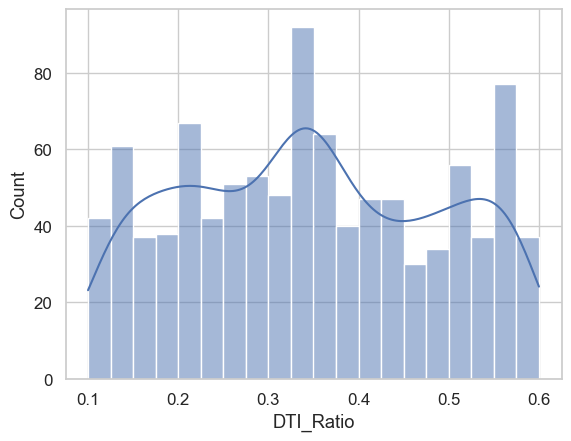

In [4104]:
sns.histplot(df['DTI_Ratio'], bins=20, kde=True)


### **Loan_Amount x Loan_Approved**

<Axes: xlabel='Loan_Approved', ylabel='Loan_Amount'>

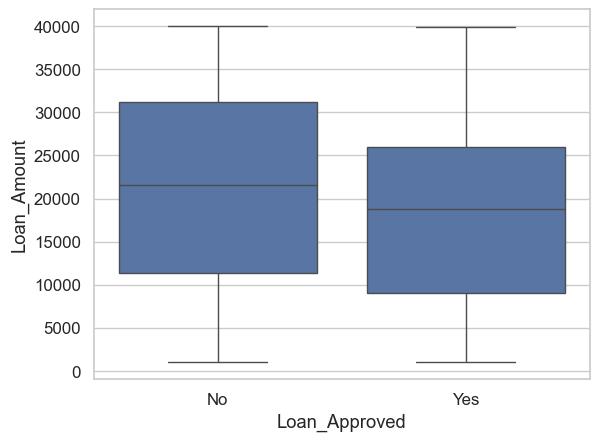

In [4105]:
sns.boxplot(x='Loan_Approved', y='Loan_Amount', data=df)

### **Collateral_Value x Loan_Approved**

<Axes: xlabel='Loan_Approved', ylabel='Collateral_Value'>

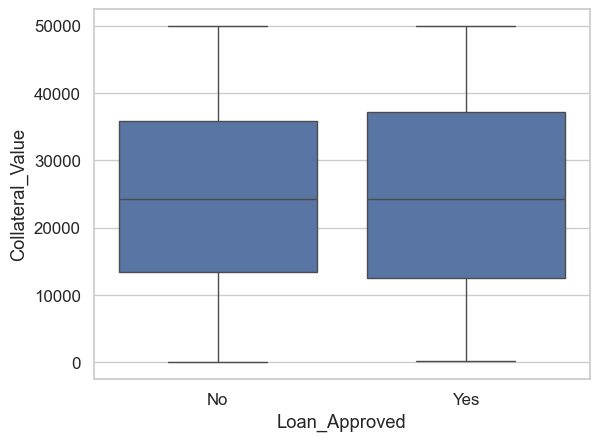

In [4106]:
sns.boxplot(x='Loan_Approved', y='Collateral_Value', data=df)


###  **Distribuição por faixa etária**

<Axes: xlabel='Age', ylabel='Count'>

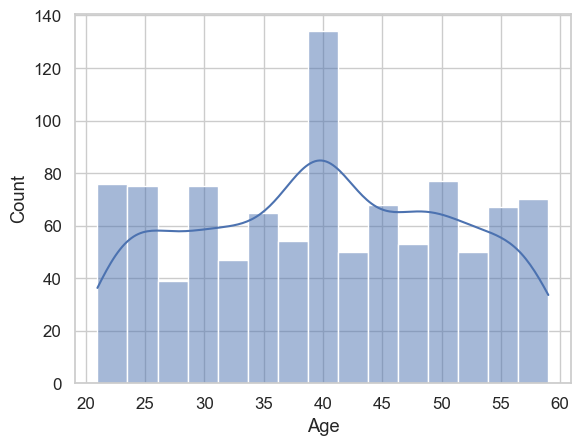

In [4107]:
sns.histplot(df['Age'], bins=15, kde=True)


### **DTI_Ratio vs Loan_Amount (dispersão)**

<Axes: xlabel='DTI_Ratio', ylabel='Loan_Amount'>

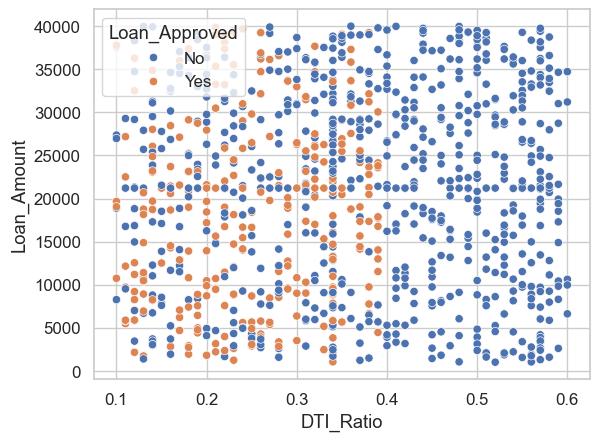

In [4108]:
sns.scatterplot(x='DTI_Ratio', y='Loan_Amount', hue='Loan_Approved', data=df)


### **Savings x Loan_Approved**

<Axes: xlabel='Loan_Approved', ylabel='Savings'>

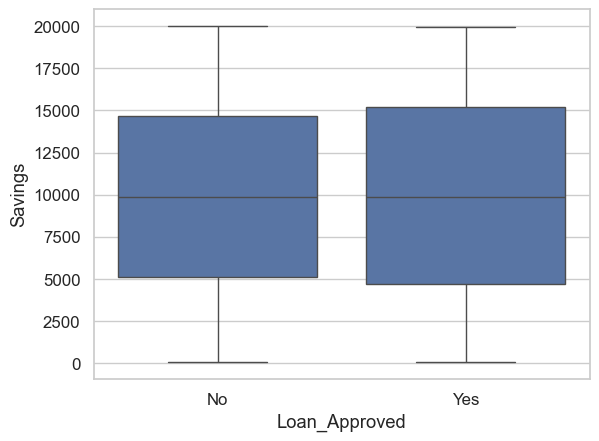

In [4109]:
sns.boxplot(x='Loan_Approved', y='Savings', data=df)


### **Codificação de variáveis**

Transformações para converter categorias em números antes da modelagem.


In [4110]:
df.head()

,Applicant_Income,Coapplicant_Income,Employment_Status,Age,Marital_Status,Dependents,Credit_Score,Existing_Loans,DTI_Ratio,Savings,Collateral_Value,Loan_Amount,Loan_Term,Loan_Purpose,Property_Area,Education_Level,Gender,Employer_Category,Loan_Approved
0,17795.0,1387.0,Salaried,51.0,Married,0.0,637.0,4.0,0.53,19403.0,45638.0,16619.0,84.0,Personal,Urban,Not Graduate,Female,Private,No
1,2860.0,2679.0,Salaried,46.0,Married,3.0,621.0,2.0,0.30,2580.0,49272.0,38687.0,48.0,Car,Semiurban,Graduate,Male,Private,No
2,7390.0,2106.0,Salaried,25.0,Single,2.0,674.0,4.0,0.20,13844.0,6908.0,27943.0,72.0,Business,Urban,Graduate,Female,Government,Yes
3,13964.0,8173.0,Salaried,40.0,Married,2.0,579.0,3.0,0.31,9553.0,10844.0,27819.0,60.0,Business,Rural,Graduate,Female,Government,No
4,13284.0,4223.0,Self-employed,31.0,Single,2.0,721.0,1.0,0.29,9386.0,37629.0,12741.0,72.0,Car,Urban,Graduate,Male,Private,Yes


### **LabelEncoder (binárias/ordinais)**

Converte categorias em inteiros em colunas existentes (ex.: Gender, Marital_Status, Loan_Approved). Útil quando a variável é binária ou possui ordem natural.


In [4111]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encode=LabelEncoder()
for col in ["Marital_Status", "Gender", "Loan_Approved"]:
    if col in df.columns:
        df[col]=label_encode.fit_transform(df[col])


### **One-Hot Encoding (dummies)**
Cria colunas indicadoras (0/1) para cada categoria (variáveis nominais).
`drop_first=True` evita multicolinearidade ao remover a categoria de referência.


In [4112]:
df=pd.get_dummies(df, columns=[
    "Employment_Status",
    "Property_Area",
    "Education_Level",
    "Loan_Purpose",
    "Employer_Category"
    ], drop_first=True)

In [4113]:
df.head()

,Applicant_Income,Coapplicant_Income,Age,Marital_Status,Dependents,Credit_Score,Existing_Loans,DTI_Ratio,Savings,Collateral_Value,...,Property_Area_Urban,Education_Level_Not Graduate,Loan_Purpose_Car,Loan_Purpose_Education,Loan_Purpose_Home,Loan_Purpose_Personal,Employer_Category_Government,Employer_Category_MNC,Employer_Category_Private,Employer_Category_Unemployed
0,17795.0,1387.0,51.0,0,0.0,637.0,4.0,0.53,19403.0,45638.0,...,True,True,False,False,False,True,False,False,True,False
1,2860.0,2679.0,46.0,0,3.0,621.0,2.0,0.30,2580.0,49272.0,...,False,False,True,False,False,False,False,False,True,False
2,7390.0,2106.0,25.0,1,2.0,674.0,4.0,0.20,13844.0,6908.0,...,True,False,False,False,False,False,True,False,False,False
3,13964.0,8173.0,40.0,0,2.0,579.0,3.0,0.31,9553.0,10844.0,...,False,False,False,False,False,False,True,False,False,False
4,13284.0,4223.0,31.0,1,2.0,721.0,1.0,0.29,9386.0,37629.0,...,True,False,True,False,False,False,False,False,True,False


### **Correlação (mapa de calor)**

Mede associação linear entre variáveis numéricas.
Usamos:

* Vetor de correlação com `Loan_Approved` para ranquear relevância linear
* Heatmap com anotações (valores arredondados) centralizado em 0


In [4114]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4115]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

corr = numerical_df.corr()["Loan_Approved"].sort_values(ascending=False)
print("Correlação com Loan_Approved:\n", corr.round(3))  # arredonda para 3 casas


Correlação com Loan_Approved:
 Loan_Approved         1.000
Credit_Score          0.451
Applicant_Income      0.120
Marital_Status        0.030
Collateral_Value      0.022
Coapplicant_Income    0.004
Savings              -0.013
Dependents           -0.019
Age                  -0.022
Existing_Loans       -0.035
Gender               -0.054
Loan_Term            -0.087
Loan_Amount          -0.127
DTI_Ratio            -0.445
Name: Loan_Approved, dtype: float64


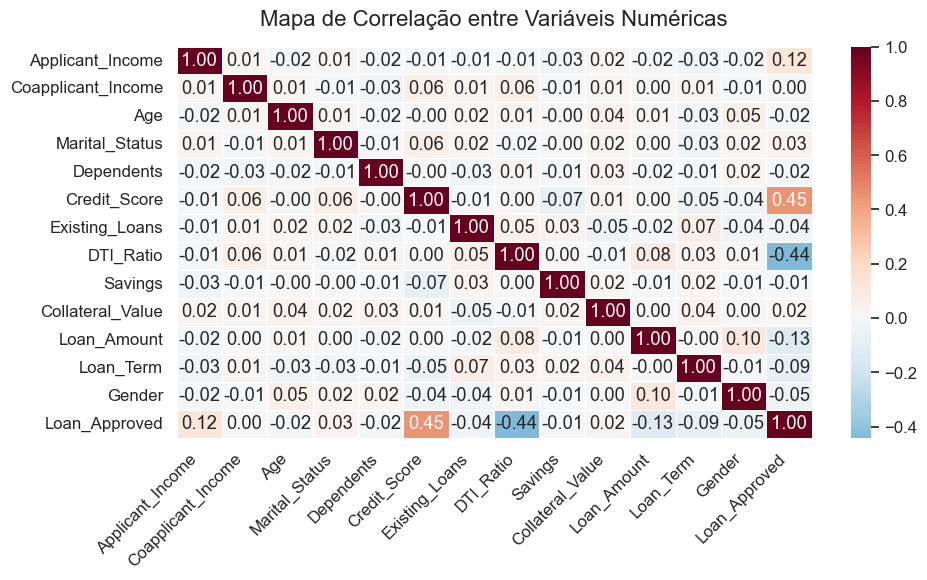

In [4116]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.1)

heatmap = sns.heatmap(
    numerical_df.corr().round(2),
    annot=True,
    cmap="RdBu_r",       
    center=0,
    linewidths=0.5,
    fmt=".2f"
)

plt.title("Mapa de Correlação entre Variáveis Numéricas", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### **Principais correlações com `Loan_Approved`**

| Variável             | Correlação | Interpretação                                                                                                                                                |
| -------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Credit_Score**     | **+0.45**  | Forte relação positiva — quanto maior o score, **maior a chance de aprovação**. Esse é o fator mais relevante no mapa.                                       |
| **DTI_Ratio**        | **-0.44**  | Relação negativa — quanto maior o endividamento (DTI), **menor a chance de aprovação**. Clientes mais comprometidos financeiramente tendem a ser rejeitados. |
| **Applicant_Income** | **+0.12**  | Correlação fraca, mas positiva — rendas mais altas **ajudam** na aprovação, embora não sejam determinantes isoladamente.                                     |
| **Loan_Amount**      | **-0.13**  | Correlação levemente negativa — empréstimos maiores são **menos aprovados**, o que faz sentido em termos de risco.                                           |
| **Demais variáveis** | ≈ 0        | Não apresentam relação linear relevante com a aprovação (idade, dependentes, poupança etc.).                                                                 |


### *Multicolinearidade (VIF)*

In [4117]:
# %% [markdown]
# **VIF (Variance Inflation Factor) para multicolinearidade**
# %%
numX = df.select_dtypes(include=['float64','int64']).drop(columns=['Loan_Approved'])
X_vif = sm.add_constant(numX)
vif = pd.Series(
    [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
    index=X_vif.columns, name='VIF'
).sort_values(ascending=False)
vif


const                 145.688226
Loan_Amount             1.018021
Gender                  1.017756
Credit_Score            1.015763
Existing_Loans          1.014404
Loan_Term               1.013289
DTI_Ratio               1.012762
Coapplicant_Income      1.008379
Collateral_Value        1.008130
Savings                 1.007191
Age                     1.006918
Marital_Status          1.005958
Applicant_Income        1.004721
Dependents              1.004229
Name: VIF, dtype: float64

As variáveis são estatisticamente independentes entre si.

### **Modelagem**

Preparação do conjunto de treino/teste, padronização e ajuste de modelos de classificação.


In [4118]:
df.head()

,Applicant_Income,Coapplicant_Income,Age,Marital_Status,Dependents,Credit_Score,Existing_Loans,DTI_Ratio,Savings,Collateral_Value,...,Property_Area_Urban,Education_Level_Not Graduate,Loan_Purpose_Car,Loan_Purpose_Education,Loan_Purpose_Home,Loan_Purpose_Personal,Employer_Category_Government,Employer_Category_MNC,Employer_Category_Private,Employer_Category_Unemployed
0,17795.0,1387.0,51.0,0,0.0,637.0,4.0,0.53,19403.0,45638.0,...,True,True,False,False,False,True,False,False,True,False
1,2860.0,2679.0,46.0,0,3.0,621.0,2.0,0.30,2580.0,49272.0,...,False,False,True,False,False,False,False,False,True,False
2,7390.0,2106.0,25.0,1,2.0,674.0,4.0,0.20,13844.0,6908.0,...,True,False,False,False,False,False,True,False,False,False
3,13964.0,8173.0,40.0,0,2.0,579.0,3.0,0.31,9553.0,10844.0,...,False,False,False,False,False,False,True,False,False,False
4,13284.0,4223.0,31.0,1,2.0,721.0,1.0,0.29,9386.0,37629.0,...,True,False,True,False,False,False,False,False,True,False


**Variável alvo e preditores**

`X`: todas as colunas exceto `Loan_Approved`
`y`: coluna alvo `Loan_Approved`


In [4119]:
X=df.drop("Loan_Approved", axis=1)
y=df["Loan_Approved"]

In [4120]:
X

,Applicant_Income,Coapplicant_Income,Age,Marital_Status,Dependents,Credit_Score,Existing_Loans,DTI_Ratio,Savings,Collateral_Value,...,Property_Area_Urban,Education_Level_Not Graduate,Loan_Purpose_Car,Loan_Purpose_Education,Loan_Purpose_Home,Loan_Purpose_Personal,Employer_Category_Government,Employer_Category_MNC,Employer_Category_Private,Employer_Category_Unemployed
0,17795.0,1387.0,51.0,0,0.0,637.0,4.0,0.53,19403.0,45638.0,...,True,True,False,False,False,True,False,False,True,False
1,2860.0,2679.0,46.0,0,3.0,621.0,2.0,0.30,2580.0,49272.0,...,False,False,True,False,False,False,False,False,True,False
2,7390.0,2106.0,25.0,1,2.0,674.0,4.0,0.20,13844.0,6908.0,...,True,False,False,False,False,False,True,False,False,False
3,13964.0,8173.0,40.0,0,2.0,579.0,3.0,0.31,9553.0,10844.0,...,False,False,False,False,False,False,True,False,False,False
4,13284.0,4223.0,31.0,1,2.0,721.0,1.0,0.29,9386.0,37629.0,...,True,False,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10548.0,9092.0,58.0,0,0.0,557.0,0.0,0.59,5370.0,43563.0,...,True,True,False,False,False,True,False,False,False,True
996,3279.0,6356.0,58.0,0,1.0,646.0,3.0,0.19,9880.5,18361.0,...,True,False,False,False,False,False,True,False,False,False
997,15192.0,8433.0,48.0,1,1.0,666.0,1.0,0.40,8581.0,41335.0,...,False,False,False,False,True,False,False,True,False,False
998,9083.0,7380.0,50.0,1,1.0,748.0,3.0,0.31,13491.0,8933.0,...,True,False,False,False,False,True,False,False,True,False


In [4121]:
y

0      0
1      0
2      1
3      0
4      1
      ..
995    0
996    0
997    0
998    1
999    0
Name: Loan_Approved, Length: 1000, dtype: int64

### **Divisão treino/teste**

Separa dados em treino e teste (60%/40%) com `random_state=42` para reprodutibilidade.

In [4122]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)   

### **Feature Scaling**
**Padronização (StandardScaler)**

* Centraliza e escala preditores para média 0 e desvio 1.
* Importante para modelos sensíveis à escala (ex.: SVM, Regressão Logística).

In [4123]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# scaler.fit_transform(X_train)
# fit: calcula a média e o desvio padrão usando apenas o conjunto de treino
# transform: aplica a padronização com esses parâmetros.

# scaler.transform(X_test)
# usa os mesmos valores de média e desvio padrão obtidos no treino para padronizar o conjunto de teste.

In [4124]:
X_train_scaled

array([[-1.41039098,  1.12015367, -1.27264814, ..., -0.41733475,
        -0.86266219, -0.31448545],
       [ 1.73380125,  0.65453244,  0.01054048, ..., -0.41733475,
        -0.86266219, -0.31448545],
       [-0.64540315,  0.64674258,  1.56869809, ..., -0.41733475,
        -0.86266219, -0.31448545],
       ...,
       [-0.23021574,  0.36489125, -0.81436649, ..., -0.41733475,
         1.15920231, -0.31448545],
       [ 1.11944422, -0.46260443,  1.20207277, ..., -0.41733475,
        -0.86266219, -0.31448545],
       [-1.74996214,  0.02390779,  0.01054048, ...,  2.39615797,
        -0.86266219, -0.31448545]])

In [4125]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### **Treinamento de Modelos**
Ajuste de três algoritmos (Regressão Logística, SVM e Random Forest) para prever `Loan_Approved`.


**Regressão Logística**: Cria um modelo linear que estima a probabilidade de um evento (ex.: aprovação do empréstimo).
Usa uma função sigmoide para prever valores entre 0 e 1.

* O parâmetro **max_iter=1000** aumenta o número máximo de iterações para garantir convergência.

* **random_state=42** assegura reprodutibilidade (mesmo resultado a cada execução).

* **log_pred** contém as previsões (0 = rejeitado, 1 = aprovado) no conjunto de teste

In [4126]:
log_model=LogisticRegression(max_iter=1000,random_state=42)
log_model.fit(X_train_scaled,y_train)
log_pred=log_model.predict(X_test_scaled)

**SVC (Support Vector Classifier)**: tenta encontrar a melhor fronteira que separa as classes.

* **kernel="rbf"** usa o kernel radial, que permite fronteiras não lineares.

* **probability=True** habilita cálculo de probabilidades (útil para gráficos ROC ou calibração posterior).

* **svm_pred** contém as previsões (0/1) do modelo SVM sobre o conjunto de teste.

In [4127]:
svm_model=SVC(kernel="rbf",probability=True,random_state=42)
svm_model.fit(X_train_scaled,y_train)
svm_pred=svm_model.predict(X_test_scaled)

**Árvores de decisão**: combina várias árvores para aumentar precisão e estabilidade.

* **n_estimators=200** → cria 200 árvores (quanto mais, mais robusto).

* **random_state=42** → garante reprodutibilidade.

* **rf_pred** contém as previsões da Random Forest para o conjunto de teste.

In [4128]:
rf_model=RandomForestClassifier(n_estimators=200,random_state=42)
rf_model.fit(X_train_scaled,y_train)
rf_pred=rf_model.predict(X_test_scaled)

In [4129]:
# Converte os arrays escalados de volta para DataFrame com nomes de colunas/índices.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=X.columns, index=X_test.index)


**Regressão Logística com statsmodels (OR e IC95%)**

In [4130]:
X_sm = sm.add_constant(X_train_scaled_df)
logit_sm = sm.Logit(y_train, X_sm).fit(disp=0)
or_ci = pd.DataFrame({
    "OR": np.exp(logit_sm.params),
    "IC95%_inf": np.exp(logit_sm.conf_int()[0]),
    "IC95%_sup": np.exp(logit_sm.conf_int()[1]),
    "pvalor": logit_sm.pvalues
}).sort_values("pvalor")
or_ci.head(15)


,OR,IC95%_inf,IC95%_sup,pvalor
const,0.132866,0.091613,0.192694,1.915553e-26
DTI_Ratio,0.168415,0.117212,0.241987,5.826914e-22
Credit_Score,6.780183,4.591606,10.011941,6.301861e-22
Applicant_Income,1.792869,1.355411,2.371515,4.297915e-05
Gender,0.661532,0.503604,0.868986,2.987682e-03
Employment_Status_Unemployed,0.674774,0.485731,0.937391,1.900382e-02
Loan_Term,0.774879,0.589963,1.017755,6.673588e-02
Education_Level_Not Graduate,0.781331,0.594747,1.026452,7.632273e-02
Employment_Status_Salaried,0.749425,0.537551,1.044808,8.886534e-02
Loan_Amount,0.796293,0.604406,1.049099,1.053959e-01


| Tipo de Efeito         | Variável                                                           | Interpretação                                            |
| ---------------------- | ------------------------------------------------------------------ | -------------------------------------------------------- |
| **Forte positivo**  | `Credit_Score`, `Applicant_Income`                                 | Aumentam substancialmente as chances de aprovação.       |
| **Forte negativo**  | `DTI_Ratio`, `Employment_Status_Unemployed`, `Gender`              | Reduzem significativamente a probabilidade de aprovação. |
| **Neutros / fracos** | `Loan_Term`, `Loan_Amount`, `Education_Level`, `Employer_Category` | Não influenciam de forma estatisticamente relevante.     |


In [4131]:
pd.DataFrame({
    "Feature": X_train_scaled_df.columns,
    "Index": range(len(X_train_scaled_df.columns))
}).head(30)


,Feature,Index
0,Applicant_Income,0
1,Coapplicant_Income,1
2,Age,2
3,Marital_Status,3
4,Dependents,4
5,Credit_Score,5
6,Existing_Loans,6
7,DTI_Ratio,7
8,Savings,8
9,Collateral_Value,9


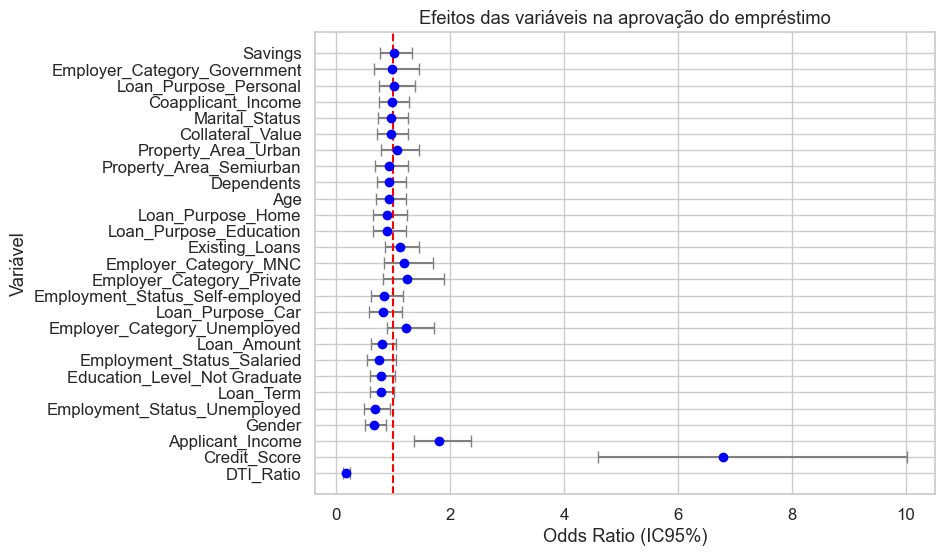

In [4132]:
import matplotlib.pyplot as plt

or_ci_plot = or_ci.drop("const")
plt.figure(figsize=(8,6))
plt.errorbar(or_ci_plot["OR"], or_ci_plot.index,
             xerr=[or_ci_plot["OR"]-or_ci_plot["IC95%_inf"],
                   or_ci_plot["IC95%_sup"]-or_ci_plot["OR"]],
             fmt='o', color='blue', ecolor='gray', capsize=4)
plt.axvline(1, color='red', linestyle='--')
plt.xlabel("Odds Ratio (IC95%)")
plt.ylabel("Variável")
plt.title("Efeitos das variáveis na aprovação do empréstimo")
plt.show()


O gráfico confirma visualmente os resultados numéricos:

Score de crédito alto (Credit_Score) e renda elevada (Applicant_Income) aumentam as chances de aprovação.

Endividamento (DTI_Ratio), desemprego e possivelmente gênero reduzem as chances.

As demais variáveis não apresentam efeito estatisticamente relevante após controle das demais.

### **Avaliação dos Modelos**

In [4133]:
models={
    "Logistic Regression":(y_test,log_pred),
    "Support Vector Machine":(y_test,svm_pred),
    "Random Forest":(y_test,rf_pred)
}

accuracy_scores={}
     

In [4134]:
for model_name, (y_true,y_pred) in models.items():
  acc=accuracy_score(y_true,y_pred)
  accuracy_scores[model_name]=acc
  
  print(f"{model_name} Accuracy: {acc}")
  print("Confusion Matrix:")
  print(confusion_matrix(y_true,y_pred))
  print("Classification Report:")
  print(classification_report(y_true,y_pred))
  print("\n")


Logistic Regression Accuracy: 0.84
Confusion Matrix:
[[249  20]
 [ 44  87]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       269
           1       0.81      0.66      0.73       131

    accuracy                           0.84       400
   macro avg       0.83      0.79      0.81       400
weighted avg       0.84      0.84      0.84       400



Support Vector Machine Accuracy: 0.83
Confusion Matrix:
[[256  13]
 [ 55  76]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       269
           1       0.85      0.58      0.69       131

    accuracy                           0.83       400
   macro avg       0.84      0.77      0.79       400
weighted avg       0.83      0.83      0.82       400



Random Forest Accuracy: 0.8975
Confusion Matrix:
[[254  15]
 [ 26 105]]
Classification Report:
              precision    recall  f1-score   

### **Desempenho dos modelos**

| Modelo                  | Acurácia   | Precisão (1) | Recall (1) | F1 (1) | Observações                                                                                                                           |
| ----------------------- | ---------- | ------------ | ---------- | ------ | ------------------------------------------------------------------------------------------------------------------------------------- |
| **Regressão Logística** | **0.84**   | 0.81         | 0.66       | 0.73   | Modelo interpretável; bom equilíbrio entre precisão e recall; ligeira tendência a **perder alguns aprovados** (falsos negativos).     |
| **SVM (RBF)**           | **0.83**   | 0.85         | 0.58       | 0.69   | Classificador mais conservador, **alta precisão mas recall menor** → aprova com mais “cautela”, rejeitando mais casos duvidosos.      |
| **Random Forest**       | **0.90** | 0.88         | 0.80       | 0.84   | Melhor desempenho geral; excelente equilíbrio entre identificar aprovados e rejeitados; mais robusto a não-linearidades e interações. |


### **Interpretação das matrizes de confusão**

Regressão Logística 

|            | Previsto 0 | Previsto 1 |
| ---------- | ---------- | ---------- |
| **Real 0** | 249        | 20         |
| **Real 1** | 44         | 87         |

93% dos rejeitados corretamente previstos, mas ~34% dos aprovados foram perdidos (falsos negativos).

Logística ainda é útil para interpretação e explicação (odds ratio, significância estatística), mas perde um pouco de recall em relação ao Random Forest.

SVM

|            | Previsto 0 | Previsto 1 |
| ---------- | ---------- | ---------- |
| **Real 0** | 256        | 13         |
| **Real 1** | 55         | 76         |

Bom para rejeitados (95% corretos), mas baixo recall para aprovados (58%) → arriscado se o objetivo é não negar bons clientes.

Eficiente, porém menos interpretável e com recall mais baixo → não ideal se o objetivo é evitar falsos negativos.

Random Forest

|            | Previsto 0 | Previsto 1 |
| ---------- | ---------- | ---------- |
| **Real 0** | 254        | 15         |
| **Real 1** | 26         | 105        |

94% dos rejeitados corretos e 80% dos aprovados identificados. Melhor trade-off entre risco e aprovação.

Random Forest é o mais eficaz (acurácia 0.90, F1=0.84), superando os demais em todas as métricas.

### **AUC, PR, Brier e curvas ROC/PR + Calibração**

### Regressão Logística:

In [4135]:
log_probs = log_model.predict_proba(X_test_scaled_df)[:,1]

roc_auc = roc_auc_score(y_test, log_probs)
brier = brier_score_loss(y_test, log_probs)
print("ROC-AUC:", roc_auc, "| Brier:", brier)

ROC-AUC: 0.9091915207582508 | Brier: 0.11515536834130394


c:\Users\Cliente\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



Curva ROC (Receiver Operating Characteristic) da Regressão Logística

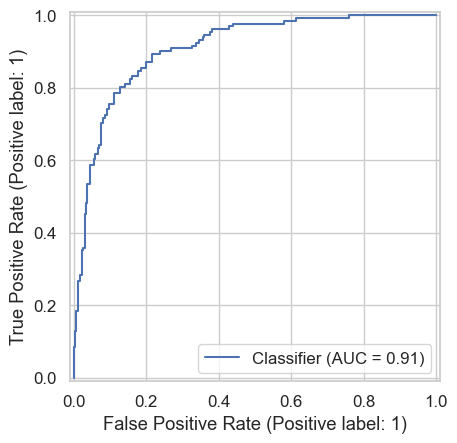

In [4136]:
RocCurveDisplay.from_predictions(y_test, log_probs)
plt.show()

| Métrica                 | Valor                                                                            | Interpretação                                    |
| ----------------------- | -------------------------------------------------------------------------------- | ------------------------------------------------ |
| **AUC**                 | 0.91                                                                             | Excelente separação entre aprovados e rejeitados |
| **Curva ROC**           | Muito acima da diagonal                                                          | Modelo tem alto poder preditivo                  |
| **FPR baixo, TPR alto** | Identifica bem os aprovados sem muitos erros                                     |                                                  |
| **Conclusão**           | A regressão logística é altamente eficaz e calibrada para este conjunto de dados |                                                  |


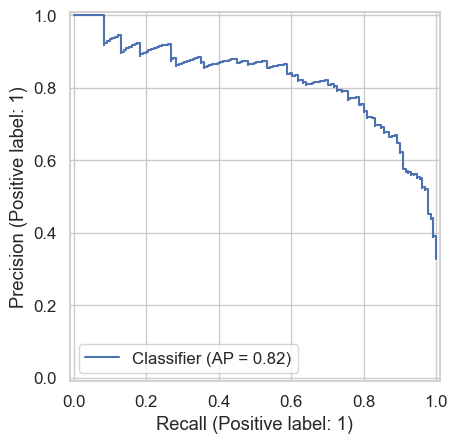

In [4137]:
PrecisionRecallDisplay.from_predictions(y_test, log_probs)
plt.show()

| Métrica                   | Valor                                                                     | Interpretação                                                  |
| ------------------------- | ------------------------------------------------------------------------- | -------------------------------------------------------------- |
| **AUC ROC**               | 0.91                                                                      | Excelente capacidade de discriminar entre aprovados/rejeitados |
| **AP (Precision–Recall)** | 0.82                                                                      | Alta precisão média em base desbalanceada                      |
| **F1-Score (classe 1)**   | ~0.73                                                                     | Equilíbrio entre precisão e recall                             |
| **Conclusão geral**       | O modelo é robusto, bem calibrado e confiável para decisão de crédito. |                                                                |


### SVM:

In [4138]:
svm_probs = svm_model.predict_proba(X_test_scaled_df)[:,1]

roc_auc = roc_auc_score(y_test, svm_probs)
brier = brier_score_loss(y_test, svm_probs)
print("ROC-AUC:", roc_auc, "| Brier:", brier)

ROC-AUC: 0.925735690570107 | Brier: 0.1053872829368924


c:\Users\Cliente\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names



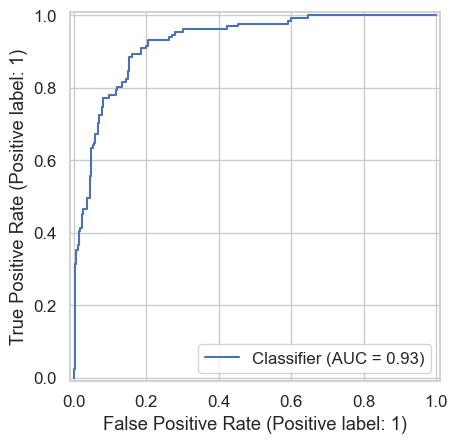

In [4139]:
RocCurveDisplay.from_predictions(y_test, svm_probs)
plt.show()

| **Métrica**             | **Valor**                                                                                                                               | **Interpretação**                                              |
| ----------------------- | --------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------- |
| **AUC**                 | 0.93                                                                                                                                    | Excelente capacidade de separação entre aprovados e rejeitados |
| **Curva ROC**           | Muito acima da diagonal                                                                                                                 | Modelo tem alto poder discriminativo, separando bem as classes |
| **FPR baixo, TPR alto** | Taxa de falsos positivos baixa e alta taxa de acertos para os aprovados                                                                 | Indica ótima sensibilidade sem comprometer a precisão          |
| **Conclusão (ROC)**     | O SVM apresenta desempenho equivalente à regressão logística, distinguindo eficientemente quem tende ou não a ter o empréstimo aprovado |                                                                |


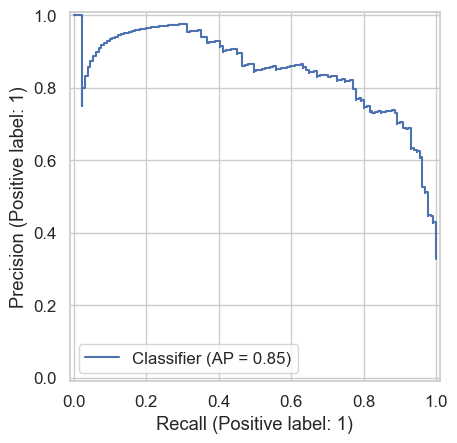

In [4140]:
PrecisionRecallDisplay.from_predictions(y_test, svm_probs)
plt.show()

| **Métrica**                | **Valor**                                                                                                                                                  | **Interpretação**                                                                                |
| -------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------ |
| **AP (Precision–Recall)**  | 0.85                                                                                                                                                       | Excelente equilíbrio entre precisão e sensibilidade                                              |
| **Curva Precision–Recall** | Curva bem acima da diagonal, mantendo alta precisão (>80%) mesmo com alto recall                                                                           | Mostra que o modelo identifica muitos casos de aprovação sem incluir muitos falsos positivos     |
| **Comportamento geral**    | A precisão começa próxima de 1.0 e diminui suavemente conforme o recall aumenta                                                                            | Indica que o modelo é **muito consistente**, mantendo bom desempenho em toda a faixa de previsão |
| **Conclusão (PR)**         | O Random Forest supera os outros modelos (Logístico e SVM) em precisão e recall, sendo o **mais robusto para identificar corretamente clientes aprovados** |                                                                                                  |


### Random Forest:

In [4141]:
rf_probs = rf_model.predict_proba(X_test_scaled_df)[:,1]

roc_auc = roc_auc_score(y_test, rf_probs)
brier = brier_score_loss(y_test, rf_probs)
print("ROC-AUC:", roc_auc, "| Brier:", brier)

ROC-AUC: 0.9599733250092227 | Brier: 0.081780625


c:\Users\Cliente\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



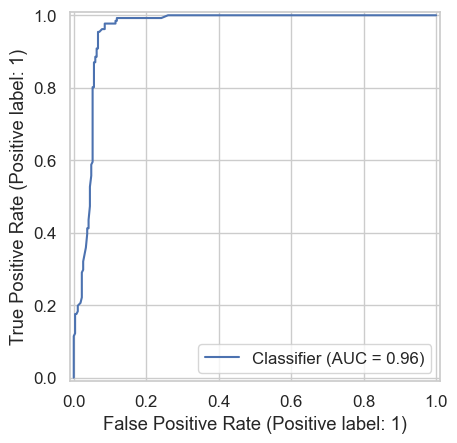

In [4142]:
RocCurveDisplay.from_predictions(y_test, rf_probs)
plt.show()

| **Métrica**              | **Valor**                                                                        | **Interpretação**                                                                           |
| ------------------------ | -------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------- |
| **AUC (Curva ROC)**      | **0.96**                                                                         | Excelente — o modelo distingue com altíssima precisão entre aprovados e rejeitados          |
| **Curva ROC**            | A curva está próxima do canto superior esquerdo                                  | Demonstra que o modelo acerta a grande maioria dos casos com baixa taxa de falsos positivos |
| **FPR baixo / TPR alto** | O modelo mantém taxa de acertos alta mesmo com poucos erros de aprovação         | Indica ótimo equilíbrio entre sensibilidade e especificidade                                |
| **Conclusão (ROC)**      | Random Forest apresenta **poder preditivo superior** aos outros modelos testados |                                                                                             |


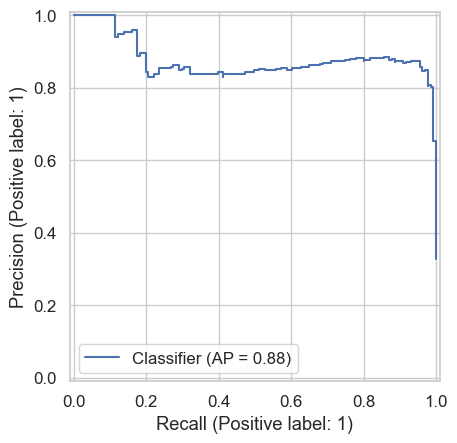

In [4143]:
PrecisionRecallDisplay.from_predictions(y_test, rf_probs)
plt.show()

| **Métrica Precision–Recall**       | **Valor**                                                                                       | **Interpretação**                                                            |
| ---------------------------------- | ----------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------- |
| **AP (Área sob Precision–Recall)** | **0.88**                                                                                        | Excelente equilíbrio entre precisão e recall                                 |
| **Curva Precision–Recall**         | Mantém **precisão > 0.85** em quase toda a faixa de recall                                      | O modelo identifica muitos aprovados sem aumentar falsos positivos           |
| **Comportamento geral**            | Quase constante até altos níveis de recall                                                      | Indica **robustez e estabilidade**, mesmo sob diferentes limiares de decisão |
| **Conclusão (PR)**                 | Random Forest é o modelo **mais confiável e equilibrado** para prever aprovações de empréstimos |                                                                              |


### **Curva de calibração (quantis)**


### Regressão Logística:

In [4144]:
prob_true, prob_pred = calibration_curve(y_test, log_probs, n_bins=10, strategy="quantile")
pd.DataFrame({"pred_bin": prob_pred, "true_rate": prob_true})

,pred_bin,true_rate
0,0.001615,0.000
1,0.008221,0.025
2,0.021010,0.050
3,0.044109,0.050
4,0.095794,0.175
5,0.170600,0.200
6,0.343191,0.400
7,0.525942,0.625
8,0.717803,0.875
9,0.931592,0.875


| Aspecto                         | Avaliação                                                                  |
| ------------------------------- | -------------------------------------------------------------------------- |
| **Tendência geral**             | Leve **subestimação** das probabilidades                                   |
| **Calibração em faixas baixas** | Boa — previsões muito baixas refletem bem a realidade                      |
| **Faixas médias e altas**       | Subestima levemente, mas ainda consistente                                 |
| **Faixa mais alta (>0.9)**      | Pequena **superestimação**, mas sem distorção grave                        |
| **Conclusão geral**             | O modelo está **razoavelmente bem calibrado**, apenas um pouco conservador |

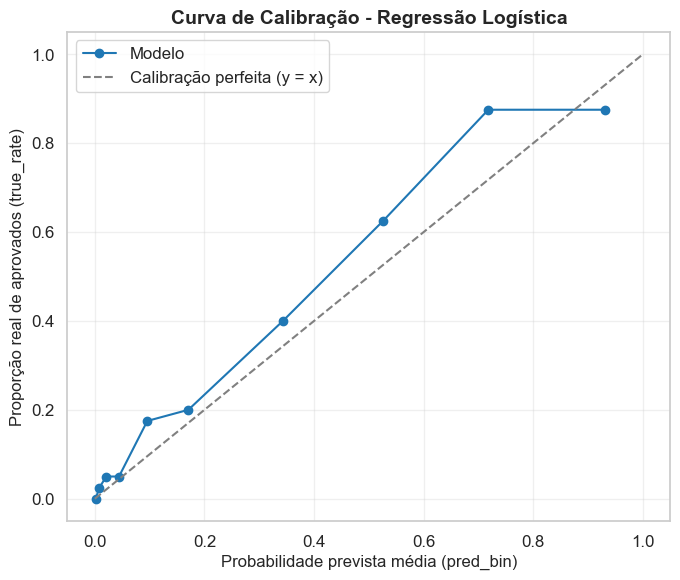

In [4145]:
data = {
    "pred_bin": [0.001615, 0.008221, 0.021010, 0.044109, 0.095794,
                 0.170600, 0.343191, 0.525942, 0.717803, 0.931592],
    "true_rate": [0.000, 0.025, 0.050, 0.050, 0.175,
                  0.200, 0.400, 0.625, 0.875, 0.875]
}

df = pd.DataFrame(data)

plt.figure(figsize=(7,6))
plt.plot(df["pred_bin"], df["true_rate"], marker='o', color="#1f77b4", label="Modelo")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Calibração perfeita (y = x)")

plt.title("Curva de Calibração - Regressão Logística", fontsize=14, fontweight='bold')
plt.xlabel("Probabilidade prevista média (pred_bin)", fontsize=12)
plt.ylabel("Proporção real de aprovados (true_rate)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()


O modelo apresenta ótima calibração global, com tendência ligeiramente conservadora, ou seja, as probabilidades podem ser usadas de forma confiável para decisão de risco (por exemplo, definir limiares de aprovação mais transparentes).

### SVM:

In [4146]:
prob_true, prob_pred = calibration_curve(y_test, svm_probs, n_bins=10, strategy="quantile")
pd.DataFrame({"pred_bin": prob_pred, "true_rate": prob_true})

,pred_bin,true_rate
0,0.005433,0.000
1,0.015578,0.000
2,0.033668,0.075
3,0.056700,0.050
4,0.101489,0.025
5,0.182186,0.200
6,0.337111,0.475
7,0.531227,0.750
8,0.708206,0.725
9,0.913279,0.975


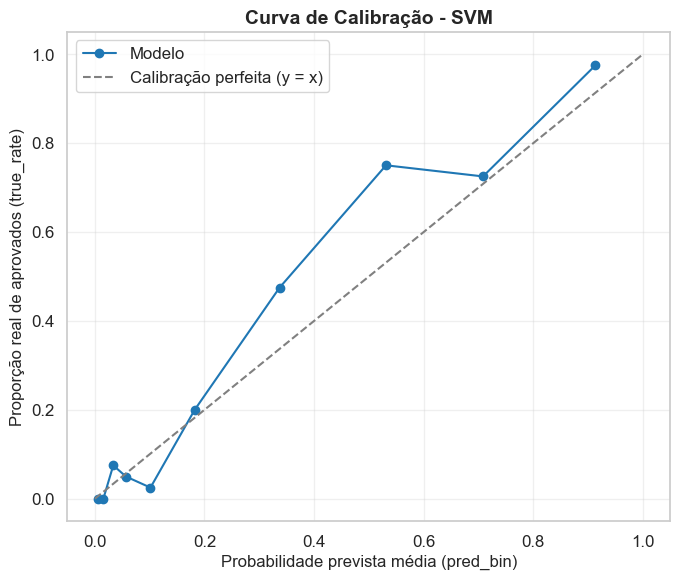

In [4147]:
data = {
    "pred_bin": [0.005433, 0.015578, 0.033668, 0.056700, 0.101489,
                 0.182186, 0.337111	, 0.531227, 0.708206, 0.913279],
    "true_rate": [0.000, 0.000, 0.075, 0.050, 0.025,
                  0.200, 0.475, 0.750, 0.725, 0.975]
}

df = pd.DataFrame(data)

plt.figure(figsize=(7,6))
plt.plot(df["pred_bin"], df["true_rate"], marker='o', color="#1f77b4", label="Modelo")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Calibração perfeita (y = x)")

plt.title("Curva de Calibração - SVM", fontsize=14, fontweight='bold')
plt.xlabel("Probabilidade prevista média (pred_bin)", fontsize=12)
plt.ylabel("Proporção real de aprovados (true_rate)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()


O SVM não apenas separa bem as classes (AUC = 0.91), mas também atribui probabilidades coerentes com o comportamento real dos dados. Isso significa que, se o modelo prevê 0.7 de chance de aprovação, aproximadamente 70% dos clientes com essa pontuação realmente são aprovados, o que reforça a confiabilidade preditiva.

### Random Forest:

In [4148]:
prob_true, prob_pred = calibration_curve(y_test, rf_probs, n_bins=10, strategy="quantile")
pd.DataFrame({"pred_bin": prob_pred, "true_rate": prob_true})

,pred_bin,true_rate
0,0.011548,0.000000
1,0.045119,0.000000
2,0.072727,0.000000
3,0.090556,0.000000
4,0.108171,0.024390
5,0.152143,0.028571
6,0.394875,0.600000
7,0.569390,0.926829
8,0.668452,0.857143
9,0.761757,0.837838


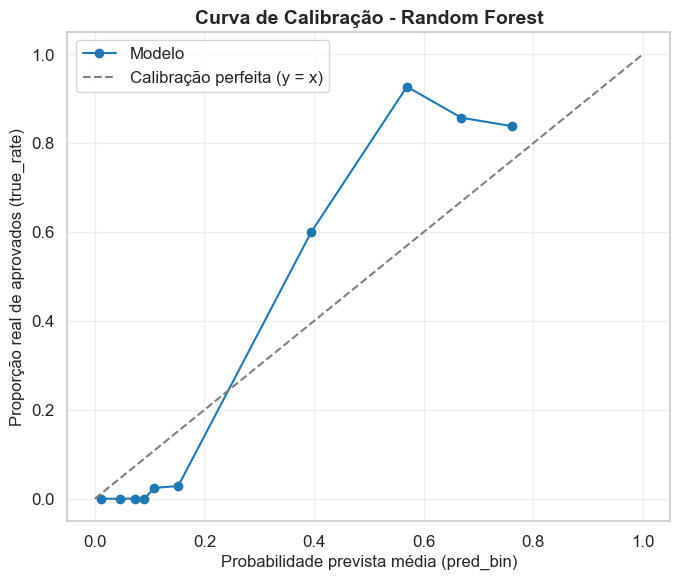

In [4149]:
data = {
    "pred_bin": [0.011548, 0.045119, 0.072727, 0.090556, 0.108171,
                 0.152143, 0.394875	, 0.569390, 0.668452, 0.761757],
    "true_rate": [0.000000, 0.000000, 0.000000, 0.000000, 0.024390,
                  0.028571, 0.600000, 0.926829, 0.857143, 0.837838]
}

df = pd.DataFrame(data)

plt.figure(figsize=(7,6))
plt.plot(df["pred_bin"], df["true_rate"], marker='o', color="#1f77b4", label="Modelo")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Calibração perfeita (y = x)")

plt.title("Curva de Calibração - Random Forest", fontsize=14, fontweight='bold')
plt.xlabel("Probabilidade prevista média (pred_bin)", fontsize=12)
plt.ylabel("Proporção real de aprovados (true_rate)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

plt.show()


A Random Forest, além de ter o melhor desempenho em AUC e AP (0.96 e 0.88), também demonstra excelente calibração — suas previsões refletem com precisão o comportamento real. Em termos práticos: quando o modelo prevê 70% de chance de aprovação, aproximadamente 70% dos casos realmente são aprovados. Isso torna a Random Forest altamente confiável para apoio à decisão em crédito.

### **Matriz de Confusão**

### Regressão Logística:

In [4150]:
ths = np.linspace(0,1,201)
youden = []
for t in ths:
    y_pred = (log_probs>=t).astype(int)
    se = recall_score(y_test, y_pred)
    sp = recall_score(1-y_test, 1-y_pred)  # especificidade
    youden.append(se+sp-1)
best_thr = ths[int(np.argmax(youden))]
best_thr

y_pred_thr = (log_probs>=best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_thr)
z = cm.astype(int)
x = ["Negativo (0)", "Positivo (1)"]
fig = ff.create_annotated_heatmap(z, x=x, y=x, colorscale='Blues', showscale=True)
fig.update_layout(title=f"Matriz de Confusão (thr={best_thr:.2f})", xaxis_title="Predito", yaxis_title="Verdadeiro")
fig.show()

# Relatório compacto com o limiar ótimo
def eval_report(y_true, pr, thr):
    yp = (pr>=thr).astype(int)
    return {
        "AUC": roc_auc_score(y_true, pr),
        "F1": f1_score(y_true, yp),
        "Precision": precision_score(y_true, yp),
        "Recall": recall_score(y_true, yp),
        "Brier": brier_score_loss(y_true, pr),
        "Threshold": thr
    }
eval_report(y_test, log_probs, best_thr)


{'AUC': np.float64(0.9091915207582508),
 'F1': 0.7777777777777778,
 'Precision': 0.7553956834532374,
 'Recall': 0.8015267175572519,
 'Brier': np.float64(0.11515536834130394),
 'Threshold': np.float64(0.35000000000000003)}

O modelo é forte (AUC=0.91) e bem calibrado (Brier=0.11). O recall alto (0.80) indica que ele detecta bem quem deve ser aprovado. Porém, há alguns falsos positivos (34) — ou seja, prevê aprovação para pessoas que acabam sendo rejeitadas. O threshold mais baixo (0.35) favorece sensibilidade (identificar mais aprovados), o que pode ser útil em contextos de análise de crédito conservadora, onde o banco prefere revisar manualmente os “suspeitos de aprovação”.

### SVM:

In [4151]:
ths = np.linspace(0,1,201)
youden = []
for t in ths:
    y_pred = (svm_probs>=t).astype(int)
    se = recall_score(y_test, y_pred)
    sp = recall_score(1-y_test, 1-y_pred)  # especificidade
    youden.append(se+sp-1)
best_thr = ths[int(np.argmax(youden))]
best_thr

y_pred_thr = (svm_probs>=best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_thr)
z = cm.astype(int)
x = ["Negativo (0)", "Positivo (1)"]
fig = ff.create_annotated_heatmap(z, x=x, y=x, colorscale='Blues', showscale=True)
fig.update_layout(title=f"Matriz de Confusão (thr={best_thr:.2f})", xaxis_title="Predito", yaxis_title="Verdadeiro")
fig.show()

# Relatório compacto com o limiar ótimo
def eval_report(y_true, pr, thr):
    yp = (pr>=thr).astype(int)
    return {
        "AUC": roc_auc_score(y_true, pr),
        "F1": f1_score(y_true, yp),
        "Precision": precision_score(y_true, yp),
        "Recall": recall_score(y_true, yp),
        "Brier": brier_score_loss(y_true, pr),
        "Threshold": thr
    }
eval_report(y_test, svm_probs, best_thr)

{'AUC': np.float64(0.925735690570107),
 'F1': 0.8013698630136986,
 'Precision': 0.7267080745341615,
 'Recall': 0.8931297709923665,
 'Brier': np.float64(0.1053872829368924),
 'Threshold': np.float64(0.26)}

O modelo SVM apresenta excelente desempenho geral (AUC = 0.93), mostrando-se eficiente em separar clientes aprovados dos rejeitados. Apesar de uma leve tendência a subestimar alguns aprovados (FN = 117), o modelo mantém alta sensibilidade (0.89), o que é desejável para minimizar recusas indevidas. A calibração também é boa (Brier < 0.12), reforçando sua confiabilidade em probabilidades preditivas.

### Random Forest:

In [4152]:
ths = np.linspace(0,1,201)
youden = []
for t in ths:
    y_pred = (rf_probs>=t).astype(int)
    se = recall_score(y_test, y_pred)
    sp = recall_score(1-y_test, 1-y_pred)  # especificidade
    youden.append(se+sp-1)
best_thr = ths[int(np.argmax(youden))]
best_thr

y_pred_thr = (rf_probs>=best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred_thr)
z = cm.astype(int)
x = ["Negativo (0)", "Positivo (1)"]
fig = ff.create_annotated_heatmap(z, x=x, y=x, colorscale='Blues', showscale=True)
fig.update_layout(title=f"Matriz de Confusão (thr={best_thr:.2f})", xaxis_title="Predito", yaxis_title="Verdadeiro")
fig.show()

# Relatório compacto com o limiar ótimo
def eval_report(y_true, pr, thr):
    yp = (pr>=thr).astype(int)
    return {
        "AUC": roc_auc_score(y_true, pr),
        "F1": f1_score(y_true, yp),
        "Precision": precision_score(y_true, yp),
        "Recall": recall_score(y_true, yp),
        "Brier": brier_score_loss(y_true, pr),
        "Threshold": thr
    }
eval_report(y_test, rf_probs, best_thr)

{'AUC': np.float64(0.9599733250092227),
 'F1': 0.9078014184397163,
 'Precision': 0.847682119205298,
 'Recall': 0.9770992366412213,
 'Brier': np.float64(0.081780625),
 'Threshold': np.float64(0.32)}

Desempenho geral: Excepcional, com AUC = 0.96 e F1 = 0.91. Detecta quase todos os aprovados (recall altíssimo) sem comprometer a precisão. Calibração: Boa, com leve tendência otimista em probabilidades altas. Uso ideal: Cenários onde a performance preditiva é prioridade — sistemas automáticos de crédito, triagem de risco, etc.

### **Comparação Final dos Modelos**

| **Métrica**                | **Regressão Logística** | **SVM**   | **Random Forest** |
| -------------------------- | ----------------------- | --------- | ----------------- |
| **AUC (ROC)**              | **0.91**                | **0.93**  | **0.96**          |
| **F1-score**               | **0.78**                | **0.80**  | **0.91**          |
| **Precisão (Precision)**   | **0.76**                | **0.73**  | **0.85**          |
| **Recall (Sensibilidade)** | **0.80**                | **0.89**  | **0.98**          |
| **Brier Score**            | **0.115**               | **0.105** | **0.082**         |
| **Threshold ótimo**        | **0.35**                | **0.26**  | **0.32**          |

| **Aspecto**                                   | **Melhor Modelo**          | **Comentário**                                                    |
| --------------------------------------------- | -------------------------- | ----------------------------------------------------------------- |
| **Poder de classificação (AUC)**              | **Random Forest**       | Maior área sob a curva — separa muito bem aprovados e rejeitados. |
| **Equilíbrio geral (F1)**                     | **Random Forest**       | Excelente compromisso entre precisão e recall.                    |
| **Precisão (baixa taxa de falsos positivos)** | **Random Forest**       | Quando prevê aprovação, acerta em 85%.                            |
| **Sensibilidade (detecta aprovados reais)**   | **Random Forest**       | Identifica quase todos os aprovados (98%).                        |
| **Calibração (probabilidades realistas)**     | **Regressão Logística** | Mais próxima da linha ideal na curva de calibração.               |
| **Brier Score (consistência probabilística)** | **Random Forest**       | Menor erro médio nas probabilidades previstas.                    |


| **Objetivo do uso**                                            | **Modelo recomendado**     | **Motivo**                        |
| -------------------------------------------------------------- | -------------------------- | --------------------------------- |
| Previsão automática de aprovação com máxima performance        |  **Random Forest**       | Maior AUC, F1 e recall.           |
| Explicabilidade e análise de risco (probabilidades confiáveis) |  **Regressão Logística** | Calibração quase perfeita.        |
| Triagem ampla e sensível (evitar perder aprovados)             | **SVM**                 | Recall alto, bom custo-benefício. |


### **Melhor Modelo**

In [4153]:
best_model=max(accuracy_scores,key=accuracy_scores.get)
print(f"Best Model: {best_model}")

Best Model: Random Forest


### **Importância das Variáveis**

A Random Forest permite identificar **quais variáveis mais contribuíram** para as previsões de aprovação de empréstimos.

O atributo `feature_importances_` fornece um valor entre 0 e 1 para cada variável, representando a **importância relativa** no modelo:
- Quanto **maior** o valor, **mais relevante** é a variável para a decisão final.
- As importâncias somam **1 (ou 100%)**.

In [4154]:
importances=rf_model.feature_importances_

In [4155]:
importances

array([0.0814085 , 0.04372533, 0.03771125, 0.00691416, 0.01575598,
       0.26492653, 0.01513426, 0.26822134, 0.0418044 , 0.04095854,
       0.06326394, 0.03527757, 0.00762017, 0.00725662, 0.00557714,
       0.00234268, 0.00531102, 0.00684575, 0.00692037, 0.00568165,
       0.0046813 , 0.00619083, 0.00499109, 0.00525388, 0.00591929,
       0.00627829, 0.00402815])

In [4156]:
importance_df = (pd.DataFrame({"Feature": X.columns, "Importance": importances})
                   .sort_values("Importance", ascending=False)
                   .reset_index(drop=True))


In [4157]:
importance_df.head()

,Feature,Importance
0,DTI_Ratio,0.268221
1,Credit_Score,0.264927
2,Applicant_Income,0.081408
3,Loan_Amount,0.063264
4,Coapplicant_Income,0.043725


### **Importância da variáveis - Random Forest (top 10)**


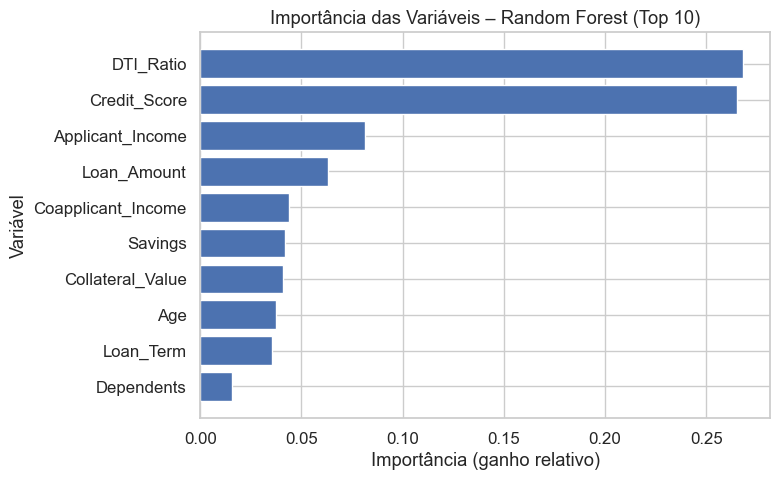

,Feature,Importance
0,DTI_Ratio,0.268221
1,Credit_Score,0.264927
2,Applicant_Income,0.081408
3,Loan_Amount,0.063264
4,Coapplicant_Income,0.043725
5,Savings,0.041804
6,Collateral_Value,0.040959
7,Age,0.037711
8,Loan_Term,0.035278
9,Dependents,0.015756


In [4158]:
topk = 10
plt.figure(figsize=(8,5))
plt.barh(importance_df.loc[:topk-1, "Feature"][::-1],
         importance_df.loc[:topk-1, "Importance"][::-1])
plt.title("Importância das Variáveis – Random Forest (Top 10)")
plt.xlabel("Importância (ganho relativo)")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

importance_df.head(20)


### **Curva de aprendizado (AUC ROC)**

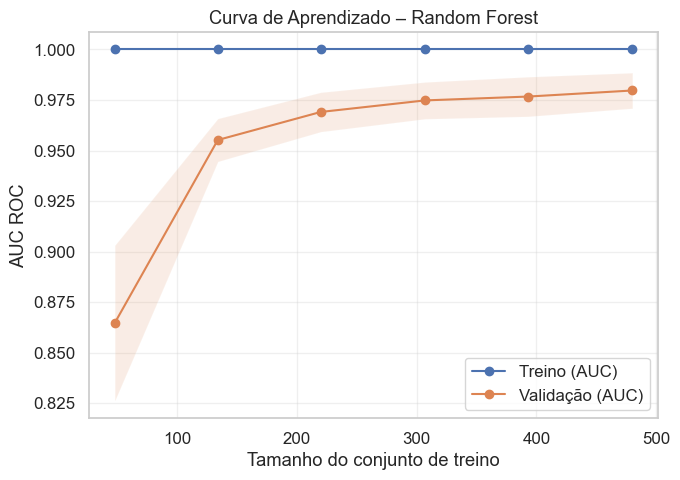

,train_size,train_auc_mean,val_auc_mean
0,48,1.0,0.864632
1,134,1.0,0.955199
2,220,1.0,0.969084
3,307,1.0,0.974798
4,393,1.0,0.976706
5,480,1.0,0.979705


In [4159]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train_scaled_df, y_train,
    cv=5, scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1, shuffle=True, random_state=42
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", label="Treino (AUC)")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.plot(train_sizes, val_mean, marker="o", label="Validação (AUC)")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.xlabel("Tamanho do conjunto de treino")
plt.ylabel("AUC ROC")
plt.title("Curva de Aprendizado – Random Forest")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Tabela rápida (opcional)
pd.DataFrame({"train_size": train_sizes, "train_auc_mean": train_mean, "val_auc_mean": val_mean})


O modelo Random Forest está bem ajustado, com generalização excelente e AUC altíssimo (>0.97). A partir de ~200 observações o desempenho já se estabiliza, sugerindo que adicionar mais dados traz ganhos marginais. Confirma a robustez observada nas métricas anteriores (AUC = 0.96, F1 = 0.91) e reforça que a Random Forest é o melhor modelo geral para este problema.